In [71]:
import torch
import timm
import matplotlib.pyplot as plt
import torch.nn as nn
import albumentations as A
import torchvision.transforms as T
from PIL import Image
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2
import numpy as np

In [72]:
# Define the HourglassModule as used during training
class HourglassModule(nn.Module):
    def __init__(self):
        super(HourglassModule, self).__init__()
        self.conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.anti_alias = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.anti_alias(x)
        x = self.conv2(x)
        return x

In [73]:
# Define the FacialLandmarkModel with HourglassModule
class FacialLandmarkModel(nn.Module):
    def __init__(self, num_landmarks):
        super(FacialLandmarkModel, self).__init__()
        self.vit_backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.vit_backbone.head = nn.Identity()  # Remove classification head

        # Reshape and HourglassModule
        self.reshape = nn.Linear(768, 256 * 14 * 14)
        self.hourglass = HourglassModule()
        self.fc = nn.Conv2d(128, num_landmarks, kernel_size=1)  # Predict heatmaps

    def forward(self, x):
        x = torch.clamp(x, min=0.0, max=1.0)  # Clamp the input values
        features = self.vit_backbone(x)
        features = self.reshape(features).view(-1, 256, 14, 14)
        features = self.hourglass(features)
        heatmaps = self.fc(features)
        return heatmaps

In [74]:
# Extract coordinates from heatmaps
def extract_landmark_coords_from_heatmaps(heatmaps):
    batch_size, num_landmarks, height, width = heatmaps.size()
    coords = torch.zeros(batch_size, num_landmarks, 2, dtype=torch.float32)

    for b in range(batch_size):
        for l in range(num_landmarks):
            heatmap = heatmaps[b, l]  # (H, W)
            heatmap = heatmap / heatmap.sum()  # Normalize heatmap values
            y_grid, x_grid = torch.meshgrid(torch.arange(height), torch.arange(width))
            coords[b, l, 0] = (heatmap * x_grid.float()).sum()  # X-coordinate
            coords[b, l, 1] = (heatmap * y_grid.float()).sum()  # Y-coordinate
    return coords

In [75]:
# Load the model
def load_model(model_path):
    model = FacialLandmarkModel(num_landmarks=68)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode
    return model

In [76]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor()
    ])
    return transform(image).unsqueeze(0)

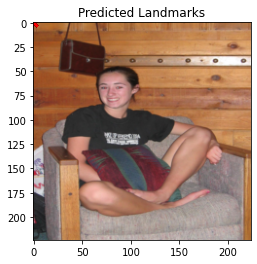

In [77]:
model_path = 'facial_landmark_model.pth'  # Path to your trained model
image_path = 'archive/ibug_300W_large_face_landmark_dataset/afw/1634816_1.jpg'  # Path to the test image

model = load_model(model_path)
image = preprocess_image(image_path)

with torch.no_grad():
        predicted_landmarks = model(image)
        #predicted_landmarks = predicted_landmarks * torch.tensor([224, 224])
height, width = 224, 224

if predicted_landmarks.min() >= 0 and predicted_landmarks.max() <= 1:
        predicted_landmarks = predicted_landmarks * torch.tensor([width, height])

# Convert image back to numpy for plotting
img_np = image[0].permute(1, 2, 0).cpu().numpy()  # (H, W, C)

plt.imshow(img_np)
plt.scatter(predicted_landmarks[0, :, 0], predicted_landmarks[0, :, 1], c='r', marker='x')
plt.title('Predicted Landmarks')
plt.show()

In [78]:
predicted_landmarks

tensor([[[[ 4.3098e-02,  8.7810e-02,  7.2574e-02,  ...,  5.8467e-02,
            6.8103e-02,  9.9385e-02],
          [ 5.8439e-03,  2.3379e-02,  7.1278e-02,  ...,  4.1647e-02,
            8.5127e-02,  7.5669e-02],
          [ 8.7190e-03,  3.1438e-03,  1.2378e-02,  ...,  7.9019e-02,
            9.6393e-02,  3.8614e-02],
          ...,
          [ 9.9080e-02,  1.9968e-02,  4.7070e-02,  ...,  7.3880e-02,
            4.9561e-02, -6.6230e-03],
          [ 4.2198e-02,  8.3771e-02,  1.0623e-01,  ...,  4.4532e-02,
            5.7152e-02,  4.1192e-02],
          [ 2.5710e-02, -1.0621e-02,  6.3646e-02,  ...,  3.6931e-02,
            3.7056e-02,  1.6847e-02]],

         [[ 1.1748e-01,  1.0407e-01,  3.8486e-02,  ...,  7.7855e-02,
            7.0680e-02,  7.4307e-02],
          [ 4.4544e-02,  6.5961e-02,  5.8580e-02,  ...,  8.6996e-02,
            5.0332e-02,  6.5011e-02],
          [ 1.0893e-01,  1.0966e-01,  9.3810e-02,  ...,  1.3467e-01,
            1.2569e-01,  7.2953e-02],
          ...,
     